In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import accelerate
from transformers import TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from imblearn.metrics import geometric_mean_score

# IMPPRES

In [2]:
from datasets import load_dataset, concatenate_datasets

In [3]:
configs = ['presupposition_all_n_presupposition', 'presupposition_both_presupposition', 'presupposition_change_of_state', 'presupposition_cleft_existence', 'presupposition_cleft_uniqueness', 'presupposition_only_presupposition', 'presupposition_possessed_definites_existence', 'presupposition_possessed_definites_uniqueness', 'presupposition_question_presupposition']

In [4]:
imppres_dataset_dicts = []
for config in configs:
    imppres_ds = load_dataset("facebook/imppres",config) 
    imppres_dataset_dicts.append(imppres_ds)

README.md:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

(…)_n_presupposition-00000-of-00001.parquet:   0%|          | 0.00/43.0k [00:00<?, ?B/s]

Generating all_n_presupposition split:   0%|          | 0/1900 [00:00<?, ? examples/s]

(…)th_presupposition-00000-of-00001.parquet:   0%|          | 0.00/41.1k [00:00<?, ?B/s]

Generating both_presupposition split:   0%|          | 0/1900 [00:00<?, ? examples/s]

change_of_state-00000-of-00001.parquet:   0%|          | 0.00/35.8k [00:00<?, ?B/s]

Generating change_of_state split:   0%|          | 0/1900 [00:00<?, ? examples/s]

cleft_existence-00000-of-00001.parquet:   0%|          | 0.00/37.6k [00:00<?, ?B/s]

Generating cleft_existence split:   0%|          | 0/1900 [00:00<?, ? examples/s]

cleft_uniqueness-00000-of-00001.parquet:   0%|          | 0.00/38.3k [00:00<?, ?B/s]

Generating cleft_uniqueness split:   0%|          | 0/1900 [00:00<?, ? examples/s]

(…)ly_presupposition-00000-of-00001.parquet:   0%|          | 0.00/38.1k [00:00<?, ?B/s]

Generating only_presupposition split:   0%|          | 0/1900 [00:00<?, ? examples/s]

(…)finites_existence-00000-of-00001.parquet:   0%|          | 0.00/38.7k [00:00<?, ?B/s]

Generating possessed_definites_existence split:   0%|          | 0/1900 [00:00<?, ? examples/s]

(…)inites_uniqueness-00000-of-00001.parquet:   0%|          | 0.00/42.1k [00:00<?, ?B/s]

Generating possessed_definites_uniqueness split:   0%|          | 0/1900 [00:00<?, ? examples/s]

(…)on_presupposition-00000-of-00001.parquet:   0%|          | 0.00/41.2k [00:00<?, ?B/s]

Generating question_presupposition split:   0%|          | 0/1900 [00:00<?, ? examples/s]

In [5]:
# concatenate all datasets together
imppres_datasets = []
for dataset_dict in imppres_dataset_dicts:
    datasets = list(dataset_dict.values())
    imppres_datasets.extend(datasets)
imppres_datasets

[Dataset({
     features: ['premise', 'hypothesis', 'trigger', 'trigger1', 'trigger2', 'presupposition', 'gold_label', 'UID', 'pairID', 'paradigmID'],
     num_rows: 1900
 }),
 Dataset({
     features: ['premise', 'hypothesis', 'trigger', 'trigger1', 'trigger2', 'presupposition', 'gold_label', 'UID', 'pairID', 'paradigmID'],
     num_rows: 1900
 }),
 Dataset({
     features: ['premise', 'hypothesis', 'trigger', 'trigger1', 'trigger2', 'presupposition', 'gold_label', 'UID', 'pairID', 'paradigmID'],
     num_rows: 1900
 }),
 Dataset({
     features: ['premise', 'hypothesis', 'trigger', 'trigger1', 'trigger2', 'presupposition', 'gold_label', 'UID', 'pairID', 'paradigmID'],
     num_rows: 1900
 }),
 Dataset({
     features: ['premise', 'hypothesis', 'trigger', 'trigger1', 'trigger2', 'presupposition', 'gold_label', 'UID', 'pairID', 'paradigmID'],
     num_rows: 1900
 }),
 Dataset({
     features: ['premise', 'hypothesis', 'trigger', 'trigger1', 'trigger2', 'presupposition', 'gold_label', '

In [6]:
imppres_datasets[2]

Dataset({
    features: ['premise', 'hypothesis', 'trigger', 'trigger1', 'trigger2', 'presupposition', 'gold_label', 'UID', 'pairID', 'paradigmID'],
    num_rows: 1900
})

In [7]:
imppres_ds = concatenate_datasets(imppres_datasets)
imppres_ds

Dataset({
    features: ['premise', 'hypothesis', 'trigger', 'trigger1', 'trigger2', 'presupposition', 'gold_label', 'UID', 'pairID', 'paradigmID'],
    num_rows: 17100
})

In [8]:
imppres_df = imppres_ds.to_pandas()
imppres_df = imppres_df[['premise','hypothesis','gold_label']]
imppres_df

,premise,hypothesis,gold_label
0,All ten guys that proved to boast were divorcing.,There are exactly ten guys that proved to boast.,0
1,All ten guys that proved to boast were divorcing.,There are exactly eleven guys that proved to b...,2
2,All ten guys that proved to boast were divorcing.,There are exactly ten senators that proved to ...,1
3,All ten guys that proved to boast weren't divo...,There are exactly ten guys that proved to boast.,0
4,All ten guys that proved to boast weren't divo...,There are exactly eleven guys that proved to b...,2
...,...,...,...
17095,If the actors do conceal where that mall shock...,Travel shocks Janet.,1
17096,The actors didn't conceal where that mall shoc...,The actors do conceal where that mall shocks J...,2
17097,Did the actors conceal where that mall shocks ...,The actors do conceal where that mall shocks J...,1
17098,The actors might have concealed where that mal...,The actors do conceal where that mall shocks J...,1


In [9]:
imppres_df.to_csv('impress.csv')

# NOPE

In [10]:
nope_ds = load_dataset("tasksource/nope",split="test")
nope_ds

README.md:   0%|          | 0.00/419 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


nli_corpus.train.jsonl:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

nli_corpus.eval.jsonl:   0%|          | 0.00/350k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2386 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/346 [00:00<?, ? examples/s]

Dataset({
    features: ['uid', 'premise', 'hypothesis', 'label', 'metadata'],
    num_rows: 346
})

In [11]:
nope_df = nope_ds.to_pandas()
nope_df = nope_df[['premise','hypothesis','label']]
nope_df

,premise,hypothesis,label
0,The cops had him in their headlights. He ran h...,He was running earlier.,E
1,The cops had him in their headlights. He ran h...,He was running earlier.,E
2,""" If somebody messes up, I usually get mad. Th...",I am mad.,N
3,""" If somebody messes up, I usually get mad. Th...",I am mad.,N
4,"In the coming months, I will return to Comite ...",My cholesterol is small and the cholesterol pa...,N
...,...,...,...
341,I've worked obviously suspicious gobblers for ...,They will react calmly.,N
342,I've worked obviously suspicious gobblers for ...,They will react calmly.,N
343,"And, of course, at that time my dad was dying,...",Something left.,N
344,I felt grubby just looking at her. I don't kn...,Kyle has a favorite hobby.,N


In [12]:
nope_df['gold_label'] = nope_df['label'].map({'E':0,'N':1,'C':2})
nope_df

,premise,hypothesis,label,gold_label
0,The cops had him in their headlights. He ran h...,He was running earlier.,E,0
1,The cops had him in their headlights. He ran h...,He was running earlier.,E,0
2,""" If somebody messes up, I usually get mad. Th...",I am mad.,N,1
3,""" If somebody messes up, I usually get mad. Th...",I am mad.,N,1
4,"In the coming months, I will return to Comite ...",My cholesterol is small and the cholesterol pa...,N,1
...,...,...,...,...
341,I've worked obviously suspicious gobblers for ...,They will react calmly.,N,1
342,I've worked obviously suspicious gobblers for ...,They will react calmly.,N,1
343,"And, of course, at that time my dad was dying,...",Something left.,N,1
344,I felt grubby just looking at her. I don't kn...,Kyle has a favorite hobby.,N,1


In [13]:
nope_df = nope_df[['premise','hypothesis','gold_label']]
nope_df

,premise,hypothesis,gold_label
0,The cops had him in their headlights. He ran h...,He was running earlier.,0
1,The cops had him in their headlights. He ran h...,He was running earlier.,0
2,""" If somebody messes up, I usually get mad. Th...",I am mad.,1
3,""" If somebody messes up, I usually get mad. Th...",I am mad.,1
4,"In the coming months, I will return to Comite ...",My cholesterol is small and the cholesterol pa...,1
...,...,...,...
341,I've worked obviously suspicious gobblers for ...,They will react calmly.,1
342,I've worked obviously suspicious gobblers for ...,They will react calmly.,1
343,"And, of course, at that time my dad was dying,...",Something left.,1
344,I felt grubby just looking at her. I don't kn...,Kyle has a favorite hobby.,1


In [14]:
test_df = pd.concat([imppres_df,nope_df])
test_df

,premise,hypothesis,gold_label
0,All ten guys that proved to boast were divorcing.,There are exactly ten guys that proved to boast.,0
1,All ten guys that proved to boast were divorcing.,There are exactly eleven guys that proved to b...,2
2,All ten guys that proved to boast were divorcing.,There are exactly ten senators that proved to ...,1
3,All ten guys that proved to boast weren't divo...,There are exactly ten guys that proved to boast.,0
4,All ten guys that proved to boast weren't divo...,There are exactly eleven guys that proved to b...,2
...,...,...,...
341,I've worked obviously suspicious gobblers for ...,They will react calmly.,1
342,I've worked obviously suspicious gobblers for ...,They will react calmly.,1
343,"And, of course, at that time my dad was dying,...",Something left.,1
344,I felt grubby just looking at her. I don't kn...,Kyle has a favorite hobby.,1


In [15]:
test_df['gold_label'].value_counts()

gold_label
1    7374
2    5519
0    4553
Name: count, dtype: int64

In [16]:
test_ds = Dataset.from_pandas(test_df)
test_ds

Dataset({
    features: ['premise', 'hypothesis', 'gold_label', '__index_level_0__'],
    num_rows: 17446
})

# Models

In [17]:
def preprocess_function(examples,tokenizer):
    try: 
        return tokenizer(examples["premise"], examples['hypothesis'], padding="max_length", truncation=True)
    except TypeError as e:
        print(f"Error processing examples: {examples['premise']}")
        raise e

In [18]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = np.mean(predictions == labels)
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')
    gmean = geometric_mean_score(labels, predictions, average='weighted')
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1_score': f1, 'gmean': gmean}

## deberta-large-mnli

In [21]:
checkpoint = "microsoft/deberta-large-mnli"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
tokenized_test_ds = test_ds.map(lambda x: preprocess_function(x, tokenizer), batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/17446 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


### Inferencing

In [23]:
from transformers import pipeline
from datasets import load_dataset, Dataset
from transformers.pipelines.pt_utils import KeyDataset, KeyPairDataset
import torch

In [24]:
if torch.cuda.is_available():
    print("GPU is available!")
    device = torch.device("cuda")
else:
    print("GPU is not available, using CPU")
    device = torch.device("cpu")

GPU is available!


In [25]:
gen = pipeline('text-classification', model=model, tokenizer=tokenizer, device=device)

Device set to use cuda


In [26]:
id_num = 0
test_results = pd.DataFrame(columns = ['id', 'premise', 'hypothesis', 'expected_label', 'predicted_label'])

for predicted in gen(KeyPairDataset(test_ds,'premise', 'hypothesis'), batch_size=8, truncation=True):
    if id_num % 100 == 0:
        print(id_num)
    test_results.loc[id_num] = [str(id_num), test_ds['premise'][id_num], test_ds['hypothesis'][id_num], test_ds['gold_label'][id_num], predicted['label']]
    id_num += 1

len(test_results)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400


17446

In [27]:
test_results

,id,premise,hypothesis,expected_label,predicted_label
0,0,All ten guys that proved to boast were divorcing.,There are exactly ten guys that proved to boast.,0,NEUTRAL
1,1,All ten guys that proved to boast were divorcing.,There are exactly eleven guys that proved to b...,2,CONTRADICTION
2,2,All ten guys that proved to boast were divorcing.,There are exactly ten senators that proved to ...,1,NEUTRAL
3,3,All ten guys that proved to boast weren't divo...,There are exactly ten guys that proved to boast.,0,NEUTRAL
4,4,All ten guys that proved to boast weren't divo...,There are exactly eleven guys that proved to b...,2,CONTRADICTION
...,...,...,...,...,...
17441,17441,I've worked obviously suspicious gobblers for ...,They will react calmly.,1,CONTRADICTION
17442,17442,I've worked obviously suspicious gobblers for ...,They will react calmly.,1,CONTRADICTION
17443,17443,"And, of course, at that time my dad was dying,...",Something left.,1,ENTAILMENT
17444,17444,I felt grubby just looking at her. I don't kn...,Kyle has a favorite hobby.,1,NEUTRAL


In [29]:
test_results['predicted_label_clean'] = test_results['predicted_label'].map({'ENTAILMENT':0,'NEUTRAL':1,'CONTRADICTION':2})

In [30]:
test_results

,id,premise,hypothesis,expected_label,predicted_label,predicted_label_clean
0,0,All ten guys that proved to boast were divorcing.,There are exactly ten guys that proved to boast.,0,NEUTRAL,1
1,1,All ten guys that proved to boast were divorcing.,There are exactly eleven guys that proved to b...,2,CONTRADICTION,2
2,2,All ten guys that proved to boast were divorcing.,There are exactly ten senators that proved to ...,1,NEUTRAL,1
3,3,All ten guys that proved to boast weren't divo...,There are exactly ten guys that proved to boast.,0,NEUTRAL,1
4,4,All ten guys that proved to boast weren't divo...,There are exactly eleven guys that proved to b...,2,CONTRADICTION,2
...,...,...,...,...,...,...
17441,17441,I've worked obviously suspicious gobblers for ...,They will react calmly.,1,CONTRADICTION,2
17442,17442,I've worked obviously suspicious gobblers for ...,They will react calmly.,1,CONTRADICTION,2
17443,17443,"And, of course, at that time my dad was dying,...",Something left.,1,ENTAILMENT,0
17444,17444,I felt grubby just looking at her. I don't kn...,Kyle has a favorite hobby.,1,NEUTRAL,1


In [31]:
test_results.to_csv('deberta_exp1_test_results.csv')

In [32]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

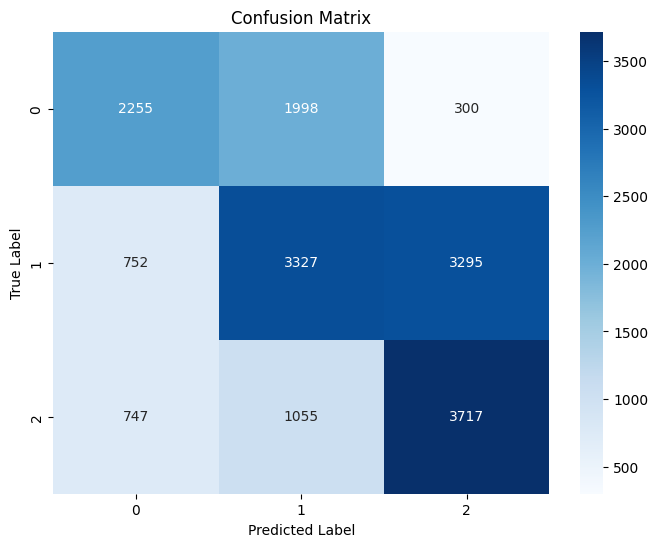

In [33]:
# Create the testing confusion matrix
cm = confusion_matrix(test_results['expected_label'], test_results['predicted_label_clean'])

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d",cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [34]:
report_dict = classification_report(test_results['expected_label'], test_results['predicted_label_clean'], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose() 
report_df.columns.name = 'label'
report_df

label,precision,recall,f1-score,support
0,0.600693,0.495278,0.542916,4553.000000
1,0.521473,0.451180,0.483787,7374.000000
2,0.508342,0.673492,0.579378,5519.000000
accuracy,0.533016,0.533016,0.533016,0.533016
macro avg,0.543503,0.539983,0.535360,17446.000000
weighted avg,0.537994,0.533016,0.529458,17446.000000


In [35]:
def compute_metrics_by_type(group):
    predictions = group['expected_label']
    labels = group['predicted_label']
    acc = np.mean(predictions == labels)
    precision = precision_score(labels, predictions,average="weighted")
    recall = recall_score(labels, predictions,average="weighted")
    f1 = f1_score(labels, predictions,average="weighted")
    return pd.Series({'accuracy': round(acc,2), 'precision': round(precision,2), 'recall': round(recall,2), 'f1_score': round(f1,2)})

## FacebookAI/roberta-large-mnli

In [19]:
checkpoint = "FacebookAI/roberta-large-mnli"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at FacebookAI/roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [74]:
tokenized_test_ds = test_ds.map(lambda x: preprocess_function(x, tokenizer), batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/17446 [00:00<?, ? examples/s]

### Inferencing

In [20]:
from transformers import pipeline
from datasets import load_dataset, Dataset
from transformers.pipelines.pt_utils import KeyDataset, KeyPairDataset
import torch

In [21]:
if torch.cuda.is_available():
    print("GPU is available!")
    device = torch.device("cuda")
else:
    print("GPU is not available, using CPU")
    device = torch.device("cpu")

GPU is available!


In [22]:
# labels = ["entailment","neutral","contradiction"]
gen = pipeline('text-classification', model=model, tokenizer=tokenizer, device=device)

Device set to use cuda


In [23]:
id_num = 0
test_results = pd.DataFrame(columns = ['id', 'premise', 'hypothesis', 'expected_label', 'predicted_label'])

for predicted in gen(KeyPairDataset(test_ds,'premise', 'hypothesis'), batch_size=8, truncation=True):
    if id_num % 100 == 0:
        print(id_num)
    test_results.loc[id_num] = [str(id_num), test_ds['premise'][id_num], test_ds['hypothesis'][id_num], test_ds['gold_label'][id_num], predicted['label']]
    id_num += 1

len(test_results)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400


17446

In [24]:
test_results

,id,premise,hypothesis,expected_label,predicted_label
0,0,All ten guys that proved to boast were divorcing.,There are exactly ten guys that proved to boast.,0,NEUTRAL
1,1,All ten guys that proved to boast were divorcing.,There are exactly eleven guys that proved to b...,2,CONTRADICTION
2,2,All ten guys that proved to boast were divorcing.,There are exactly ten senators that proved to ...,1,NEUTRAL
3,3,All ten guys that proved to boast weren't divo...,There are exactly ten guys that proved to boast.,0,NEUTRAL
4,4,All ten guys that proved to boast weren't divo...,There are exactly eleven guys that proved to b...,2,CONTRADICTION
...,...,...,...,...,...
17441,17441,I've worked obviously suspicious gobblers for ...,They will react calmly.,1,CONTRADICTION
17442,17442,I've worked obviously suspicious gobblers for ...,They will react calmly.,1,CONTRADICTION
17443,17443,"And, of course, at that time my dad was dying,...",Something left.,1,ENTAILMENT
17444,17444,I felt grubby just looking at her. I don't kn...,Kyle has a favorite hobby.,1,ENTAILMENT


In [25]:
test_results['predicted_label']

0              NEUTRAL
1        CONTRADICTION
2              NEUTRAL
3              NEUTRAL
4        CONTRADICTION
             ...      
17441    CONTRADICTION
17442    CONTRADICTION
17443       ENTAILMENT
17444       ENTAILMENT
17445       ENTAILMENT
Name: predicted_label, Length: 17446, dtype: object

In [26]:
test_results['predicted_label_clean'] = test_results['predicted_label'].map({'entailment':0,'neutral':1,'contradiction':2})
test_results

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,premise,hypothesis,expected_label,predicted_label,predicted_label_clean
0,0,All ten guys that proved to boast were divorcing.,There are exactly ten guys that proved to boast.,0,NEUTRAL,NaN
1,1,All ten guys that proved to boast were divorcing.,There are exactly eleven guys that proved to b...,2,CONTRADICTION,NaN
2,2,All ten guys that proved to boast were divorcing.,There are exactly ten senators that proved to ...,1,NEUTRAL,NaN
3,3,All ten guys that proved to boast weren't divo...,There are exactly ten guys that proved to boast.,0,NEUTRAL,NaN
4,4,All ten guys that proved to boast weren't divo...,There are exactly eleven guys that proved to b...,2,CONTRADICTION,NaN
...,...,...,...,...,...,...
17441,17441,I've worked obviously suspicious gobblers for ...,They will react calmly.,1,CONTRADICTION,NaN
17442,17442,I've worked obviously suspicious gobblers for ...,They will react calmly.,1,CONTRADICTION,NaN
17443,17443,"And, of course, at that time my dad was dying,...",Something left.,1,ENTAILMENT,NaN
17444,17444,I felt grubby just looking at her. I don't kn...,Kyle has a favorite hobby.,1,ENTAILMENT,NaN


In [27]:
test_results.to_csv('roberta_exp1_test_results.csv')

In [83]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

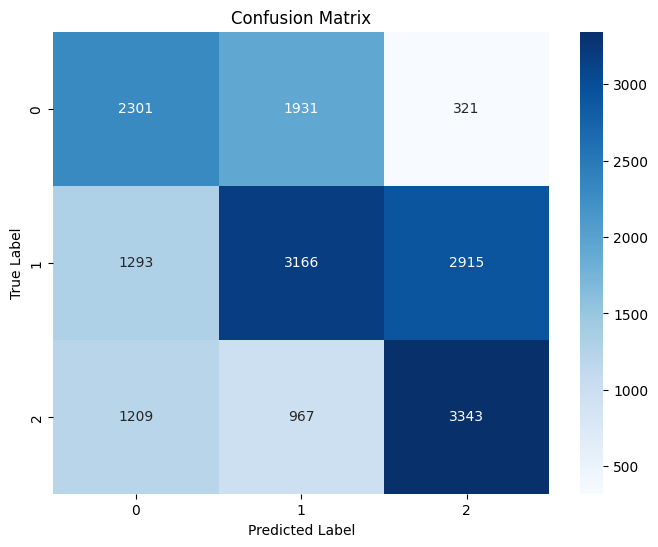

In [85]:
# Create the testing confusion matrix
cm = confusion_matrix(test_results['expected_label'], test_results['predicted_label_clean'])

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d",cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [86]:
report_dict = classification_report(test_results['expected_label'], test_results['predicted_label_clean'], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose() 
report_df.columns.name = 'label'
report_df

label,precision,recall,f1-score,support
0,0.479076,0.505381,0.491877,4553.000000
1,0.522098,0.429346,0.471201,7374.000000
2,0.508132,0.605726,0.552653,5519.000000
accuracy,0.504987,0.504987,0.504987,0.504987
macro avg,0.503102,0.513484,0.505244,17446.000000
weighted avg,0.506452,0.504987,0.502364,17446.000000


In [125]:
metrics_by_type = test_results.groupby('type').apply(compute_metrics_by_type).reset_index()
metrics_by_type.columns.name = 'ID'
metrics_by_type

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

ID,type,accuracy,precision,recall,f1_score
0,type1_again,0.45,0.45,0.45,0.43
1,type1_possessive,0.51,0.42,0.51,0.44
2,type2_again,0.41,0.35,0.41,0.37
3,type2_possessive,0.43,0.40,0.43,0.41
4,type3_again,0.43,0.54,0.43,0.48
5,type3_possessive,0.46,0.44,0.46,0.44
6,type4_possessive,0.69,0.98,0.69,0.80
7,type5_again,0.98,0.96,0.98,0.97
8,type5_possessive,0.83,0.91,0.83,0.85
